# Claims Analysis v0.1 — Multi-File, Date Range, Pareto, Aging, and Open Claims Summary

This notebook analyzes dealer claims from multiple Excel files, applies a date range filter, computes performance and Pareto tables, and summarizes open claims and aging buckets by warehouse.

In [15]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 140)

In [16]:
# %%
# ----------------------------
# Parameters (EDITABLE)
# ----------------------------
INPUT_FILES = [
    {"name": "Claims", "filename": "Claims.xlsx"},
    {"name": "Chrysler Claims", "filename": "Chrysler Claims.xlsx"},
]
SHEET_NAME = "Tasks"
OUTPUT_XLSX = Path("Claims_Performance_Summary_ALL.xlsx")
WAREHOUSES = ["OKC", "Atlanta", "Orlando", "Ontario", "El Paso", "Flowood", "Phoenix", "Charlotte"]
MAIN_WAREHOUSES = ["OKC", "Phoenix", "Ontario", "El Paso", "Flowood", "Orlando", "Atlanta", "Charlotte"]
TOP_N_LABELS = 15
DATE_FILTER_MODE = "Created"
START_DATE = "2025-01-01"
END_DATE = "2025-09-01"
BUCKET_ORDER = ["<30 days", "30-<60 days", "60-<90 days", ">= 90 days"]
bucket_regex_map = {
    r'^\s*<\s*30.*$'                 : '<30 days',
    r'^\s*30\s*-\s*<\s*60.*$'        : '30-<60 days',
    r'^\s*60\s*-\s*<\s*90.*$'        : '60-<90 days',
    r'^\s*(?:>=?\s*90|90\+|>\s*90).*': '>= 90 days',
}

In [17]:
# %%
def resolve_path(fname: str) -> Path:
    p = Path(fname)
    if p.exists():
        return p
    fallback = Path("/mnt/data") / fname
    if fallback.exists():
        return fallback
    raise FileNotFoundError(f"Could not find input Excel '{fname}' at {p.resolve()} or {fallback.resolve()}")

def load_and_prepare(path: Path, sheet: str, dataset_name: str) -> pd.DataFrame:
    xls = pd.ExcelFile(path)
    if sheet not in xls.sheet_names:
        raise ValueError(f"Sheet '{sheet}' not found in {path.name}. Available: {xls.sheet_names}")
    df = pd.read_excel(path, sheet_name=sheet)
    required = ["Bucket Name", "Labels", "Created Date", "Completed Date"]
    for col in required:
        if col not in df.columns:
            raise ValueError(f"Expected column '{col}' not found in {path.name}/{sheet}")
    df["Bucket Name"] = df["Bucket Name"].astype(str).str.strip()
    df["Labels"] = df["Labels"].astype(str).str.strip()
    df["Created Date"] = pd.to_datetime(df["Created Date"], errors="coerce")
    df["Completed Date"] = pd.to_datetime(df["Completed Date"], errors="coerce")
    df["Cycle Time (Days)"] = (df["Completed Date"] - df["Created Date"]).dt.days
    df["Dataset"] = dataset_name
    return df

def apply_date_filter(df: pd.DataFrame, mode: str, start_str, end_str) -> pd.DataFrame:
    if not start_str and not end_str:
        return df.copy()
    start = pd.to_datetime(start_str) if start_str else None
    end = pd.to_datetime(end_str) if end_str else None
    created = df["Created Date"]
    completed = df["Completed Date"]
    def in_range(series):
        mask = pd.Series(True, index=series.index)
        if start is not None:
            mask &= series >= start
        if end is not None:
            mask &= series <= end
        return mask
    if mode.lower().startswith("created"):
        mask = in_range(created)
    elif mode.lower().startswith("completed"):
        mask = in_range(completed)
    else:
        mask = in_range(created)
        mask |= in_range(completed)
    return df[mask].copy()

def explode_labels(df: pd.DataFrame) -> pd.DataFrame:
    out = df[["Dataset", "Bucket Name", "Labels"]].copy()
    out = out.assign(Labels=out["Labels"].str.split(";")).explode("Labels")
    out["Labels"] = out["Labels"].astype(str).str.strip()
    out = out[out["Labels"].ne("")]
    return out

def compute_bucket_perf(df: pd.DataFrame) -> pd.DataFrame:
    agg = (
        df.groupby(["Dataset", "Bucket Name"])["Cycle Time (Days)"]
          .agg(["count", "mean", "median", "min", "max"])
          .reset_index()
    )
    agg.rename(columns={
        "count": "Count",
        "mean": "Mean (days)",
        "median": "Median (days)",
        "min": "Min (days)",
        "max": "Max (days)"
    }, inplace=True)
    agg["Mean (days)"] = agg["Mean (days)"].round(2)
    agg["Median (days)"] = agg["Median (days)"].round(2)
    return agg

def compute_overall_pareto(labels_exploded: pd.DataFrame) -> pd.DataFrame:
    vc = labels_exploded["Labels"].value_counts().rename_axis("Label").reset_index(name="Count")
    total = vc["Count"].sum()
    vc["Cumulative %"] = (vc["Count"].cumsum() / total * 100).round(2)
    vc.insert(0, "Dataset", "ALL")
    return vc

def compute_by_wh_pareto(labels_exploded: pd.DataFrame, warehouses: list[str]) -> pd.DataFrame:
    wh = labels_exploded[labels_exploded["Bucket Name"].isin(warehouses)].copy()
    wh.rename(columns={"Bucket Name": "Warehouse"}, inplace=True)
    counts = (
        wh.groupby(["Dataset", "Warehouse", "Labels"])
          .size()
          .reset_index(name="Count")
    )
    counts["Percent"] = counts.groupby(["Dataset", "Warehouse"])["Count"].transform(lambda x: x / x.sum() * 100).round(2)
    counts = counts.sort_values(["Dataset", "Warehouse", "Count"], ascending=[True, True, False])
    counts["Cumulative %"] = counts.groupby(["Dataset", "Warehouse"])["Count"].transform(lambda x: (x.cumsum() / x.sum() * 100)).round(2)
    return counts

def plot_pareto(sub: pd.DataFrame, title: str, top_n=None):
    sub_sorted = sub.sort_values("Count", ascending=False)
    if top_n is not None:
        sub_sorted = sub_sorted.head(int(top_n))
    labels = sub_sorted["Labels"].tolist()
    counts = sub_sorted["Count"].tolist()
    cum_pct = sub_sorted["Cumulative %"].tolist()
    fig = plt.figure(figsize=(10, 5))
    ax1 = plt.gca()
    ax1.bar(labels, counts)
    ax1.set_xlabel("Label")
    ax1.set_ylabel("Count")
    ax1.set_title(title)
    ax2 = ax1.twinx()
    ax2.plot(range(len(labels)), cum_pct, marker="o")
    ax2.set_ylabel("Cumulative %")
    ax2.set_ylim(0, 100)
    ax1.tick_params(axis="x", rotation=45, labelsize=9)
    fig.tight_layout()
    plt.show()

In [18]:
# %%
frames = []
missing = []
for item in INPUT_FILES:
    try:
        p = resolve_path(item["filename"])
        df_i = load_and_prepare(p, SHEET_NAME, dataset_name=item["name"])
        frames.append(df_i)
        print(f"Loaded {len(df_i):,} rows from {item['filename']} as dataset '{item['name']}'")
    except Exception as e:
        missing.append((item["filename"], str(e)))
        print(f"WARNING: Skipping '{item['filename']}' -> {e}")

if not frames:
    raise RuntimeError("No datasets loaded. Ensure input files exist.")

df_all = pd.concat(frames, ignore_index=True)
print(f"Before date filter: {len(df_all):,} rows")

df_filtered = apply_date_filter(df_all, DATE_FILTER_MODE, START_DATE, END_DATE)
print(f"After date filter ({DATE_FILTER_MODE}, {START_DATE} to {END_DATE}): {len(df_filtered):,} rows")
df_filtered.head(3)

Loaded 3,466 rows from Claims.xlsx as dataset 'Claims'
Loaded 2,657 rows from Chrysler Claims.xlsx as dataset 'Chrysler Claims'
Before date filter: 6,123 rows
After date filter (Created, 2025-01-01 to 2025-09-01): 3,349 rows


,Task ID,Task Name,Bucket Name,Progress,Priority,Assigned To,Created By,Created Date,Start date,Due date,Is Recurring,Late,Completed Date,Completed By,Completed Checklist Items,Checklist Items,Labels,Description,Cycle Time (Days),Dataset
0,-0qzZOLigUCL_5_jyscqrWUAEUa6,CHARLOTTE - CHRYSLER SHORTAGE - 1308667 - 6843...,Charlotte,Completed,Medium,Scott Grady;Janet Jones,Former member,2025-01-13,01/13/2025,01/28/2025,False,False,2025-02-05,Heather LaMar,5/7,Credit Memo (Acctg);Email Marketa to remove fr...,DD/DB Shortage,NaN,23.0,Claims
7,-94D9gbcmE6cCIxP3vcSl2UAP12N,ATLANTA - CHRYSLER SHORTAGE - 0831173 - MULTI ...,Chrysler Pending Set Up - Shortages,Completed,Medium,NaN,Former member,2025-02-10,02/10/2025,02/14/2025,False,False,2025-02-12,Heather LaMar,0/6,Credit Memo (Acctg);Email Marketa to remove fr...,DD/DB Shortage,NaN,2.0,Claims
8,-9Hm2TdIvE-mILH0mZaAXWUAMnMB,FL3Z7902FRM - 05530 - BANNER FORD OF MONROE - ...,Flowood,Not started,Medium,Megan McLaughlin;Nidia Jimenez;Kristi Thompson...,Megan McLaughlin,2025-07-28,07/28/2025,09/01/2025,False,False,NaT,NaN,2/9,Add to Log (Acctg);Pick Up Sheet/RMA completed...,CD - Conceal damaged,NaN,NaN,Claims


In [19]:
# %%
bucket_perf_by_dataset = compute_bucket_perf(df_filtered)
df_filtered_all = df_filtered.copy()
df_filtered_all["Dataset"] = "ALL"
bucket_perf_all = compute_bucket_perf(df_filtered_all)
bucket_perf_by_dataset.head(10)
bucket_perf_all.head(10)

,Dataset,Bucket Name,Count,Mean (days),Median (days),Min (days),Max (days)
0,ALL,900,4,23.75,23.5,16.0,32.0
1,ALL,900-SHORTAGE PROBLEMS,4,35.75,20.0,15.0,88.0
2,ALL,Atlanta,101,52.40,41.0,1.0,138.0
3,ALL,CD Claims for AER/Holman customers,33,35.48,36.0,13.0,64.0
4,ALL,Charlotte,102,34.78,27.5,0.0,156.0
5,ALL,Chrysler Credits Pending - Shortages,366,43.60,38.5,7.0,210.0
6,ALL,Chrysler Pending Set Up - Shortages,27,5.63,6.0,1.0,12.0
7,ALL,Chrysler Pending Set-Up - Shortages,472,6.86,5.0,0.0,19.0
8,ALL,Claim template,0,NaN,NaN,NaN,NaN
9,ALL,El Paso,13,28.46,29.0,3.0,55.0


7. Pareto Calcuations

In [20]:
# %%
labels_exploded = explode_labels(df_filtered)
overall_all = compute_overall_pareto(labels_exploded)
overall_by_dataset = (
    labels_exploded.groupby(["Dataset", "Labels"])
                   .size().reset_index(name="Count")
                   .sort_values(["Dataset", "Count"], ascending=[True, False])
)
overall_by_dataset["Cumulative %"] = (
    overall_by_dataset.groupby("Dataset")["Count"].transform(lambda x: x.cumsum() / x.sum() * 100)
).round(2)

by_wh = compute_by_wh_pareto(labels_exploded, WAREHOUSES)
labels_exploded_all = labels_exploded.copy()
labels_exploded_all["Dataset"] = "ALL"
by_wh_all = compute_by_wh_pareto(labels_exploded_all, WAREHOUSES)
overall_all.head(15)

,Dataset,Label,Count,Cumulative %
0,ALL,DD/DB Shortage,2535,68.53
1,ALL,CD - Concealed Damage,382,78.86
2,ALL,CD - Conceal damaged,242,85.40
3,ALL,Shelf Count,115,88.51
4,ALL,AER Filed Claim,54,89.97
5,ALL,Outbound freight damage,41,91.08
6,ALL,DB short engines & transmissions,33,91.97
7,ALL,CF Misboxed,29,92.75
8,ALL,Scrap Part,24,93.40
9,ALL,SHELF COUNT,23,94.03


8. Pareto Charts

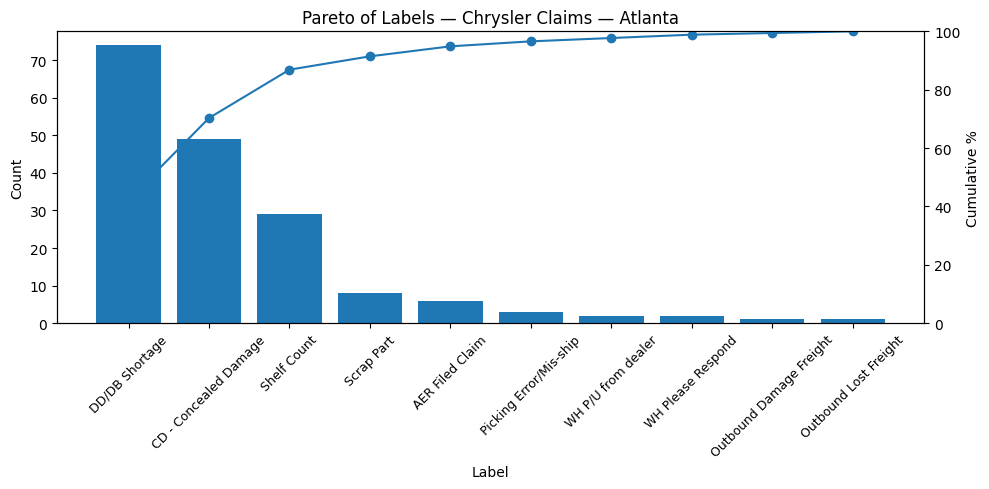

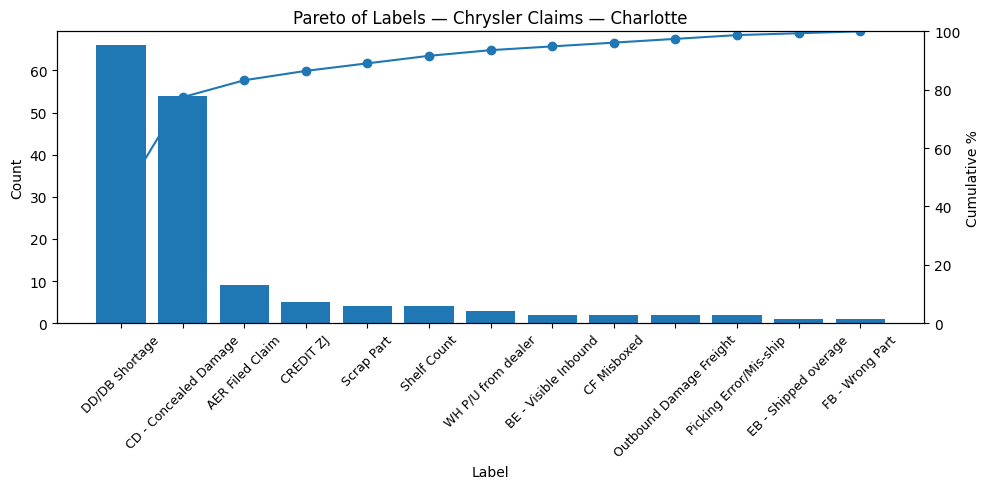

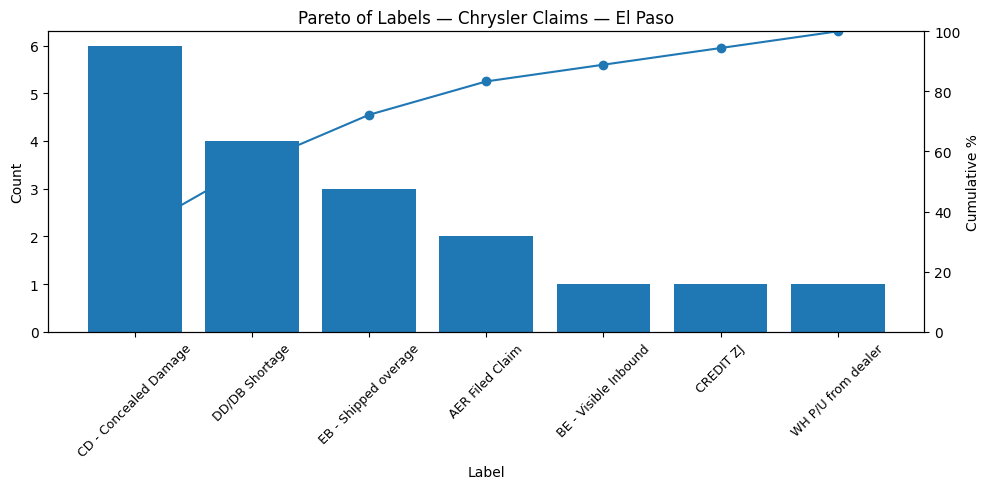

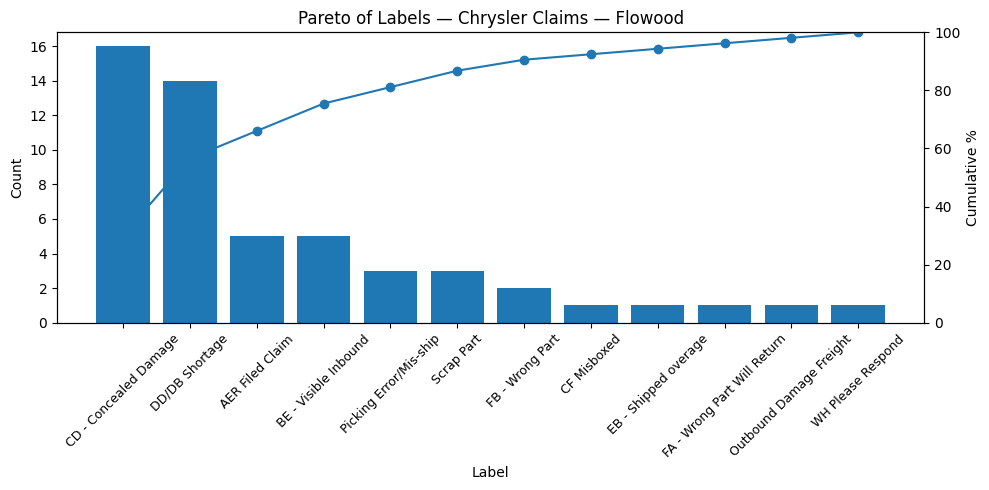

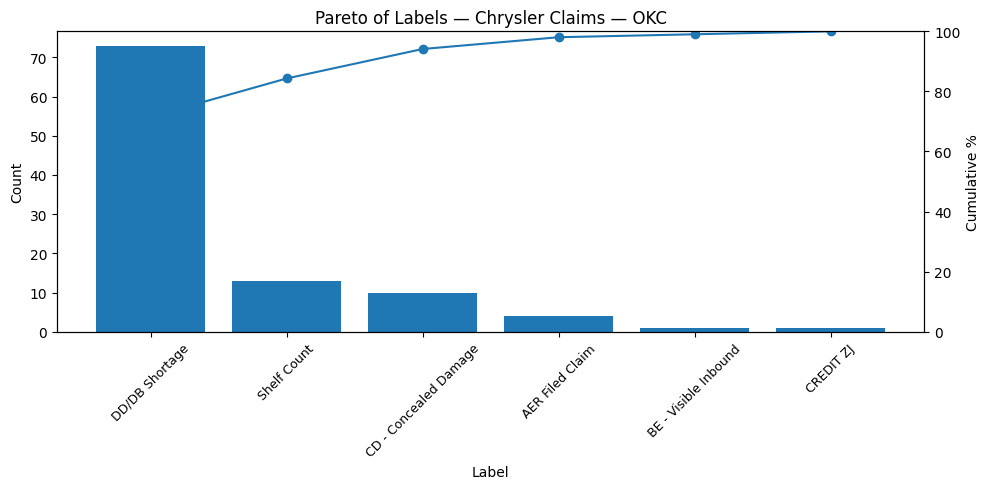

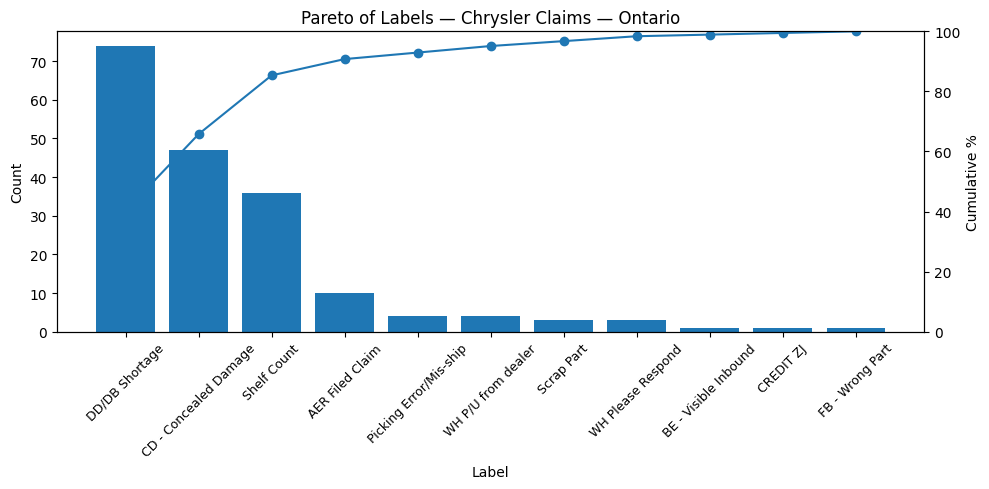

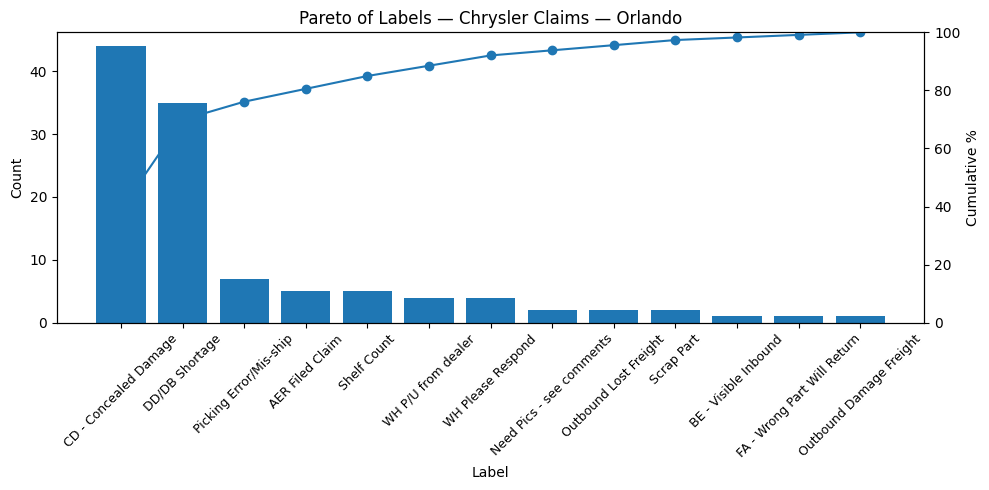

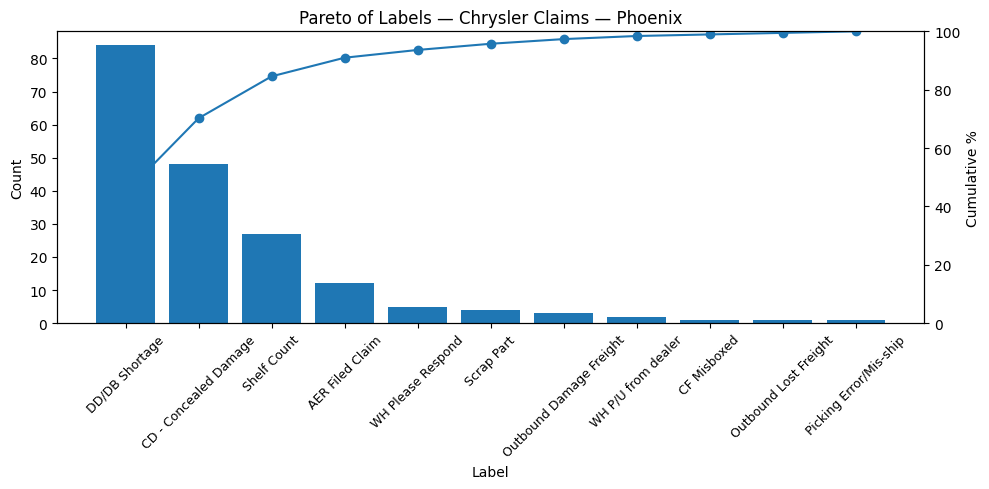

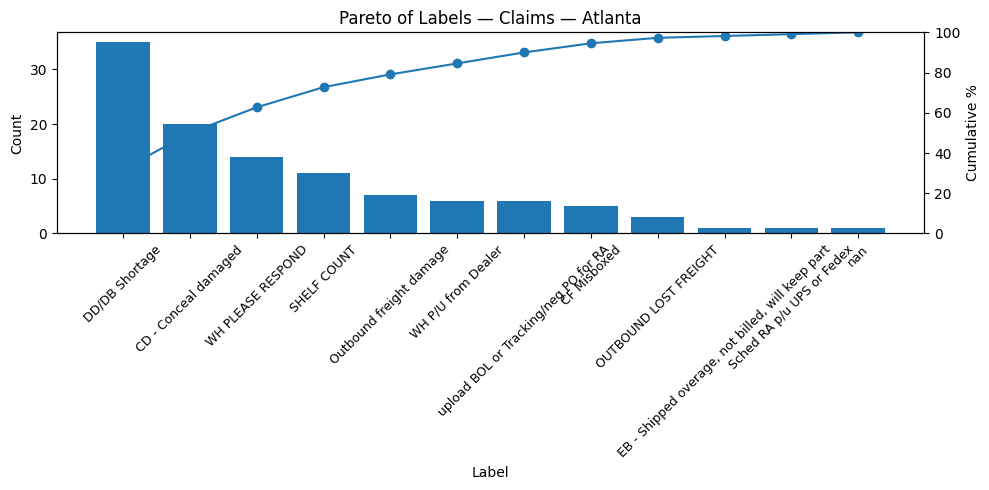

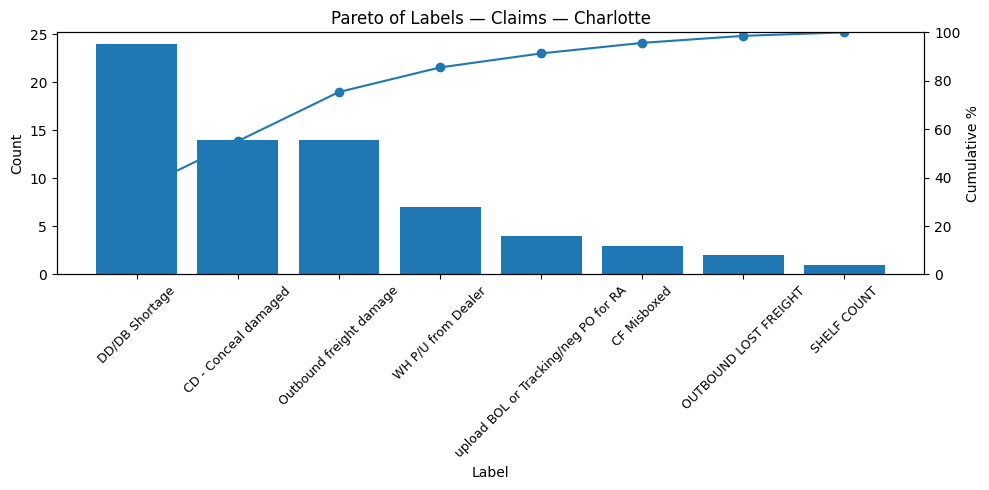

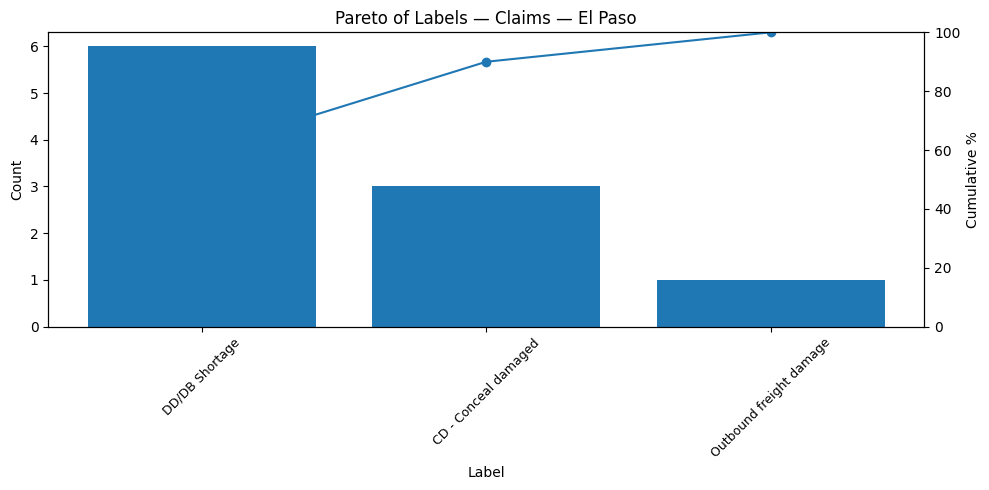

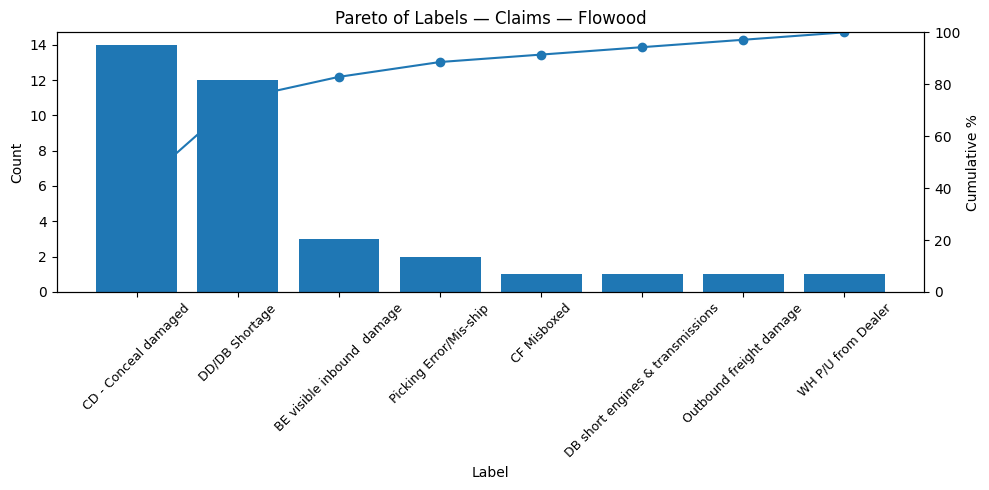

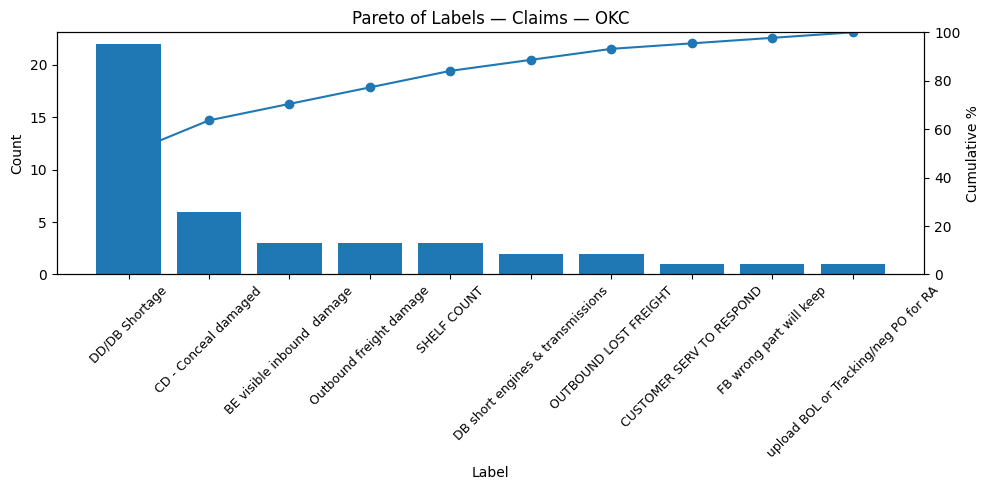

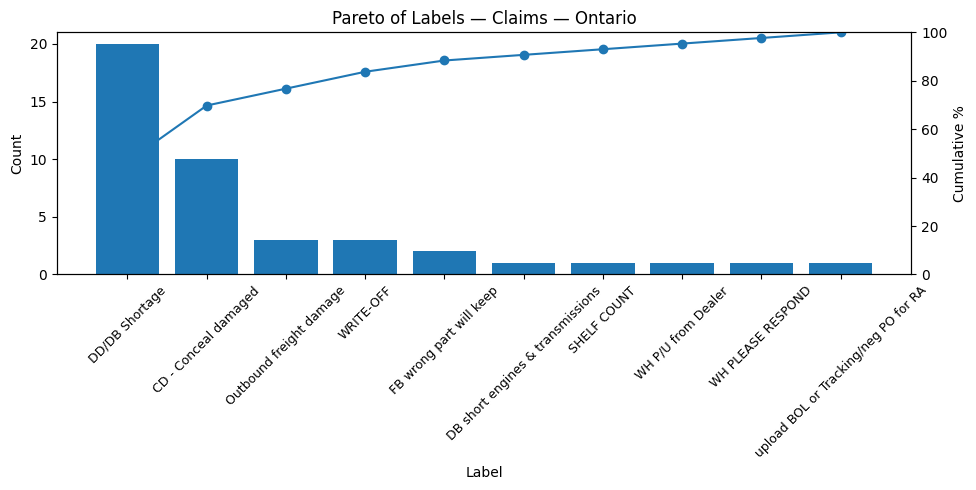

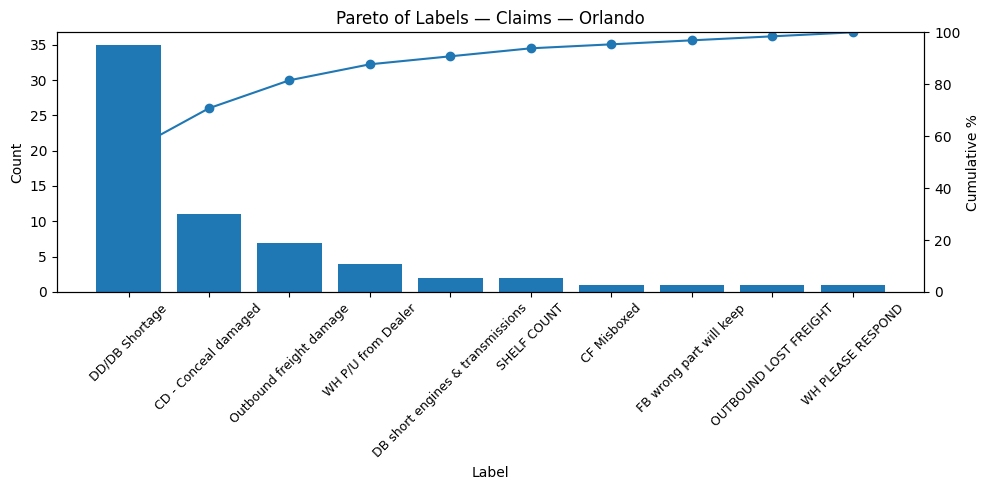

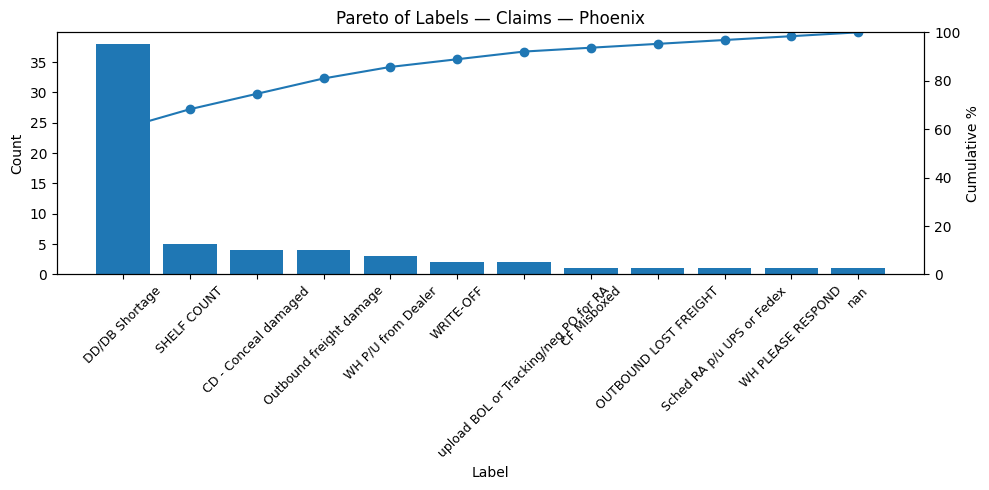

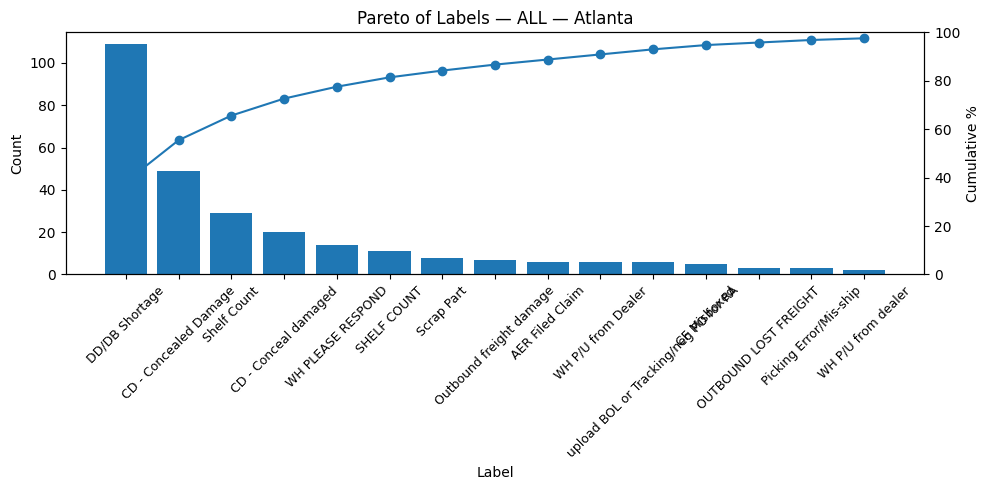

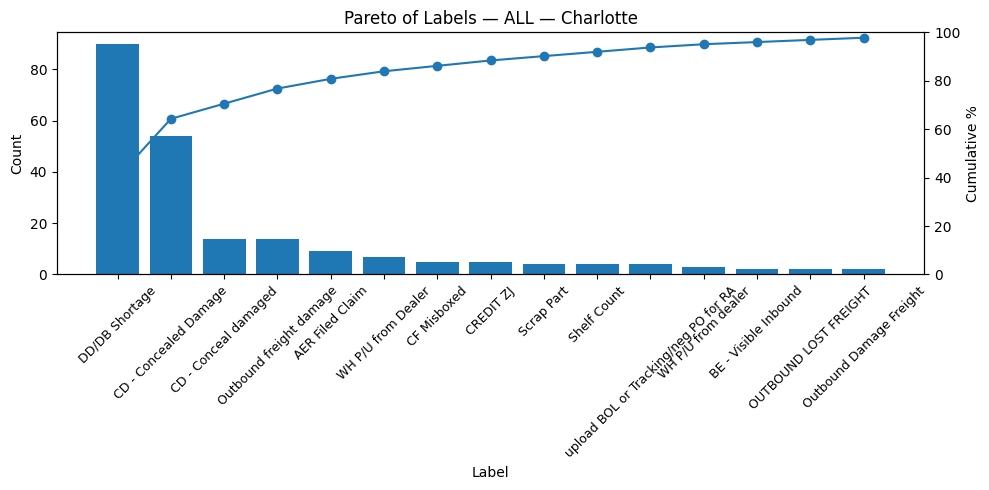

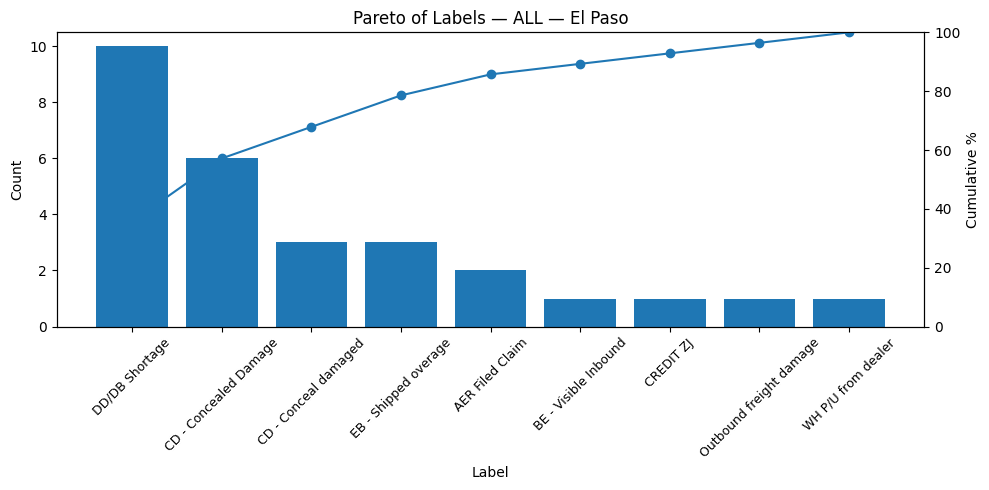

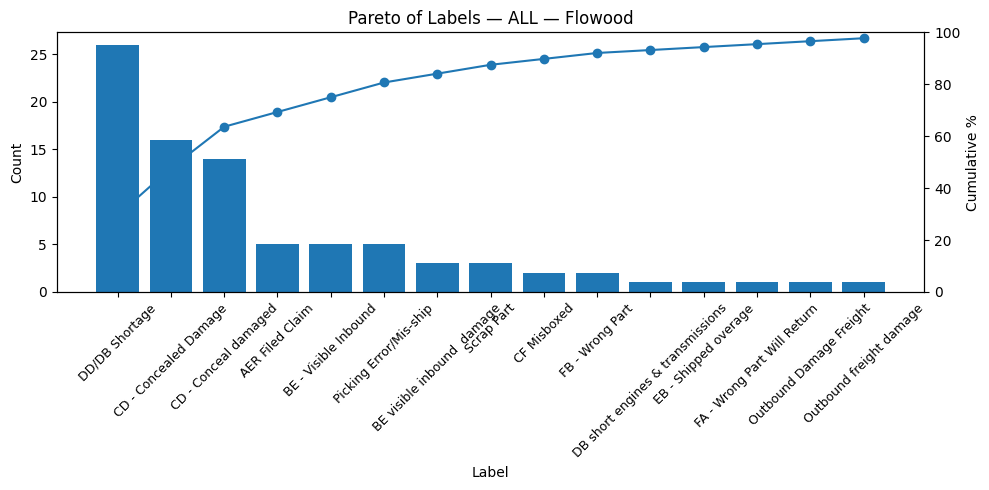

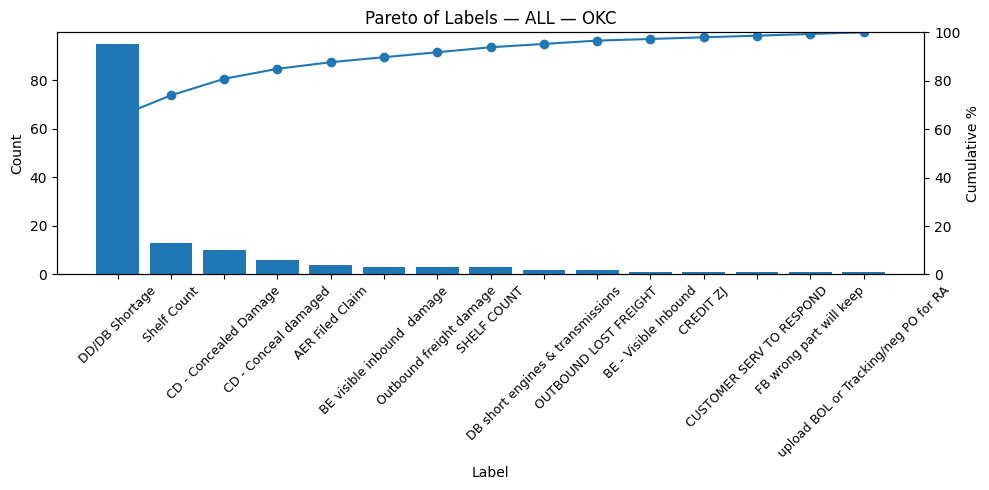

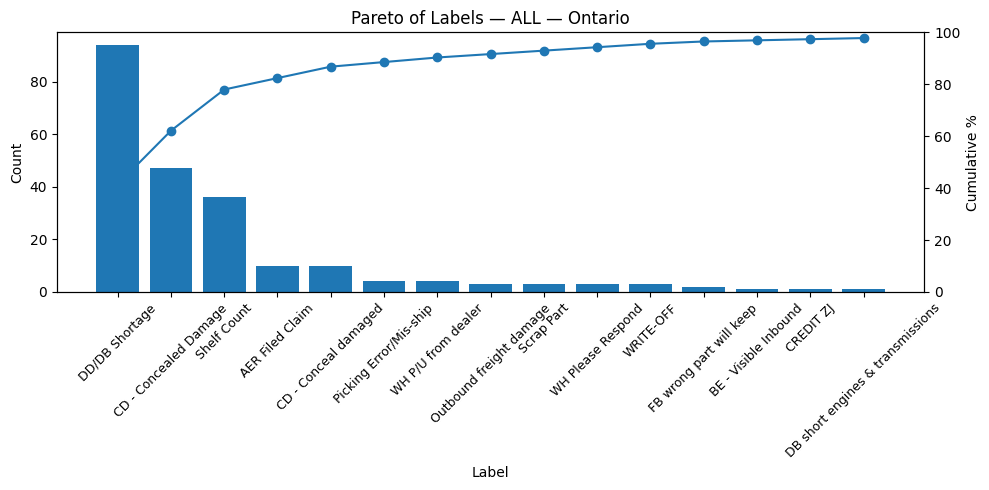

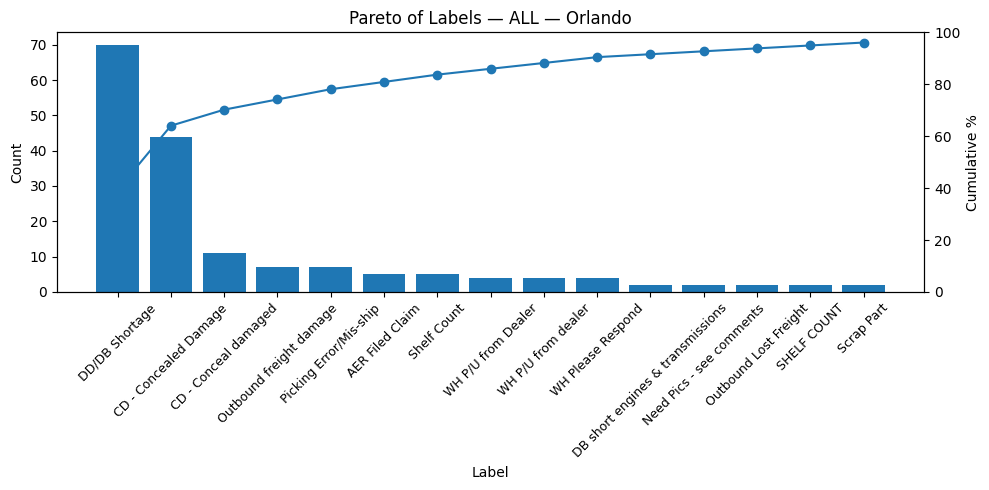

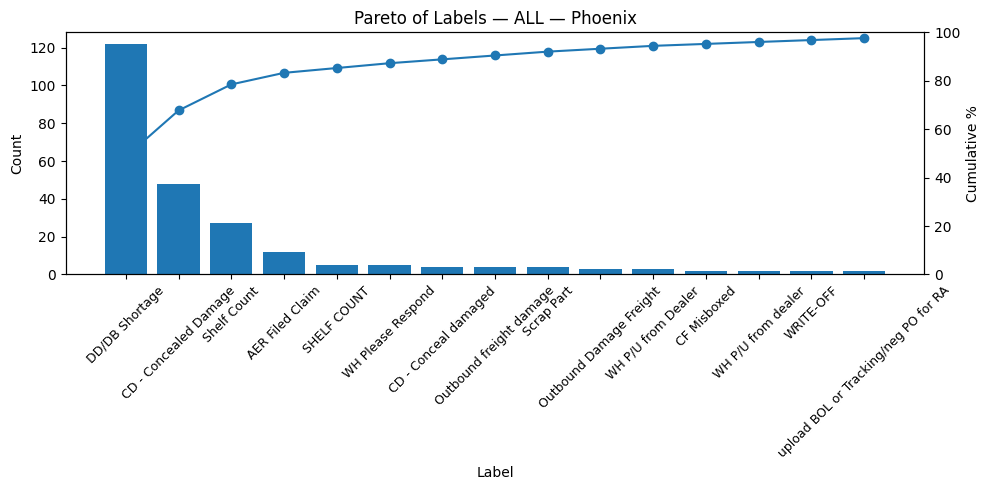

In [21]:
# %%
for ds in sorted(by_wh["Dataset"].unique()):
    for wh in sorted(by_wh[by_wh["Dataset"] == ds]["Warehouse"].unique()):
        sub = by_wh[(by_wh["Dataset"] == ds) & (by_wh["Warehouse"] == wh)]
        if not sub.empty:
            plot_pareto(sub, f"Pareto of Labels — {ds} — {wh}", top_n=TOP_N_LABELS)

for wh in sorted(by_wh_all["Warehouse"].unique()):
    sub = by_wh_all[by_wh_all["Warehouse"] == wh]
    if not sub.empty:
        plot_pareto(sub, f"Pareto of Labels — ALL — {wh}", top_n=TOP_N_LABELS)

9. Export Results

In [22]:
# %%
overall_all_export = overall_all.copy()
overall_by_dataset_export = overall_by_dataset.copy()
overall_combined = pd.concat([overall_all_export, overall_by_dataset_export], ignore_index=True)
by_wh_combined = pd.concat([by_wh, by_wh_all], ignore_index=True)

with pd.ExcelWriter(OUTPUT_XLSX, engine="openpyxl") as writer:
    bucket_perf_by_dataset.to_excel(writer, sheet_name="Bucket_Performance", index=False)
    bucket_perf_all.to_excel(writer, sheet_name="Bucket_Performance_ALL", index=False)
    overall_combined.to_excel(writer, sheet_name="Pareto_Labels_Overall", index=False)
    by_wh_combined.to_excel(writer, sheet_name="Pareto_Labels_By_Warehouse", index=False)
    df_filtered.to_excel(writer, sheet_name="Detailed_Data", index=False)
print(f"Exported (filtered) Power BI workbook -> {OUTPUT_XLSX.resolve()}")

Exported (filtered) Power BI workbook -> C:\Users\dbalan\Desktop\Python\Github\Claims\Claims_Performance_Summary_ALL.xlsx


10. Open Claims Summary by Warehouse

In [23]:
# %%
def _normalize_name(s: str) -> str:
    return str(s).strip().lower()

def _find_col(actual_cols, candidates):
    lookup = {_normalize_name(c): c for c in actual_cols}
    for cand in candidates:
        key = _normalize_name(cand)
        if key in lookup:
            return lookup[key]
    raise KeyError(f"None of the candidates {candidates} found in columns: {list(actual_cols)}")

def _pick_claims_df():
    candidates = ["df_filtered", "df_all", "df", "tasks", "claims"]
    for name in candidates:
        if name in globals() and isinstance(globals()[name], pd.DataFrame):
            df = globals()[name]
            try:
                _ = df.columns
            except Exception:
                continue
            return df, name
    raise RuntimeError(
        "Could not find a DataFrame in variables: df_filtered, df_all, df, tasks, claims.\n"
        "Please ensure your claims data is in one of those variables."
    )

_src_df, _src_name = _pick_claims_df()
claims_df = _src_df.copy()
cols = list(claims_df.columns)
bucket_candidates   = ["Bucket Name", "Bucket", "Warehouse", "Location", "Site", "Facility"]
completed_candidates = ["Completed Date", "Completed", "Date Completed", "Completion Date", "Closed Date"]
dataset_candidates   = ["Dataset"]

try:
    bucket_col = _find_col(cols, bucket_candidates)
except KeyError as e:
    raise KeyError("Could not detect your warehouse/bucket column. "
                   "Add one of these: 'Bucket Name', 'Bucket', 'Warehouse', 'Location', 'Site', 'Facility'.") from e

try:
    completed_col = _find_col(cols, completed_candidates)
except KeyError as e:
    raise KeyError("Could not detect your completed-date column. "
                   "Add one of these: 'Completed Date', 'Completed', 'Date Completed', 'Completion Date', 'Closed Date'.") from e

has_dataset = False
if any(_normalize_name(c) == "dataset" for c in cols):
    dataset_col = [c for c in cols if _normalize_name(c) == "dataset"][0]
    has_dataset = True

open_mask = claims_df[completed_col].isna()
open_df = claims_df.loc[open_mask].copy()
open_df["Warehouse"] = open_df[bucket_col]
group_fields = ["Warehouse"]
if has_dataset:
    group_fields.insert(0, dataset_col)

open_by_wh = (
    open_df
    .groupby(group_fields)
    .size()
    .reset_index(name="Open Count")
    .sort_values(group_fields + ["Open Count"], ascending=[True]*len(group_fields) + [False])
    .reset_index(drop=True)
)

print("Open claims by warehouse" + (" (by Dataset)" if has_dataset else "") + ":")
display(open_by_wh.head(100))

if has_dataset:
    open_by_wh_all = (
        open_by_wh
        .assign(**{dataset_col: "ALL"})
        .groupby([dataset_col, "Warehouse"], as_index=False)
        .agg({"Open Count": "sum"})
        .sort_values(["Warehouse"])
        .reset_index(drop=True)
    )
    print("\nOpen claims by warehouse — ALL datasets combined:")
    display(open_by_wh_all.head(100))

try:
    if "OUTPUT_XLSX" in globals():
        with pd.ExcelWriter(OUTPUT_XLSX, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
            open_by_wh.to_excel(writer, sheet_name="Open_Claims_By_Warehouse_Addon", index=False)
            if has_dataset:
                open_by_wh_all.to_excel(writer, sheet_name="Open_Claims_By_Warehouse_Addon_ALL", index=False)
        print(f"\n(Appended open-claims summaries to {OUTPUT_XLSX})")
except Exception as e:
    print(f"\nSkipping Excel export of open-claims summary: {e}")

Open claims by warehouse (by Dataset):


,Dataset,Warehouse,Open Count
0,Chrysler Claims,Atlanta,61
1,Chrysler Claims,CD Claims for AER/Holman customers,76
2,Chrysler Claims,Charlotte,58
3,Chrysler Claims,Chrysler Credits Pending - Shortages,554
4,Chrysler Claims,Chrysler Pending Set-Up - Shortages,1
5,Chrysler Claims,El Paso,8
6,Chrysler Claims,Flowood,20
7,Chrysler Claims,OKC,19
8,Chrysler Claims,Ontario,73
9,Chrysler Claims,Orlando,45



Open claims by warehouse — ALL datasets combined:


,Dataset,Warehouse,Open Count
0,ALL,900,1
1,ALL,Atlanta,99
2,ALL,CD Claims for AER/Holman customers,76
3,ALL,Charlotte,80
4,ALL,Chrysler Credits Pending - Shortages,554
5,ALL,Chrysler Pending Set-Up - Shortages,1
6,ALL,Claim template,4
7,ALL,El Paso,11
8,ALL,Flowood,38
9,ALL,Ford Credits Pending - Damages,21


c:\Users\dbalan\Desktop\Python\Github\Claims\.venv\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")



(Appended open-claims summaries to Claims_Performance_Summary_ALL.xlsx)


11. Aging Pareto for Main Warehouses

In [24]:
# %%
def _resolve_aging_source():
    if 'aging_long' in globals():
        df = aging_long.copy()
    elif 'aging_long_all' in globals():
        df = aging_long_all.copy()
        cols = {c.lower(): c for c in df.columns}
        wh_col = cols.get('warehouse', 'Warehouse') if 'warehouse' in cols else 'Warehouse'
        bucket_col = next((c for c in df.columns if 'bucket' in c.lower()), 'Aging Bucket')
        count_col = ('Open Count' if 'Open Count' in df.columns
                     else next((c for c in df.columns if c.lower() in ('open count','count','n')), None))
        if count_col is None:
            raise KeyError("Could not find an 'Open Count' (or similar) column in aging_long_all.")
        df = (df.groupby([wh_col, bucket_col], as_index=False)[count_col]
                .sum()
                .rename(columns={wh_col: 'Warehouse', bucket_col: 'Aging Bucket', count_col: 'Open Count'}))
    else:
        raise NameError("Neither 'aging_long' nor 'aging_long_all' is defined. Run the cell that builds them before Cell 15.")

    rename_map = {}
    for c in df.columns:
        cl = c.lower()
        if cl == 'warehouse': rename_map[c] = 'Warehouse'
        if 'bucket' in cl:     rename_map[c] = 'Aging Bucket'
        if cl == 'open count': rename_map[c] = 'Open Count'
    df = df.rename(columns=rename_map)

    req = {'Warehouse', 'Aging Bucket', 'Open Count'}
    missing = req - set(df.columns)
    if missing:
        raise KeyError(f"Required columns missing: {missing}. Available: {list(df.columns)}")

    return df

src = _resolve_aging_source()
src["Warehouse"] = src["Warehouse"].astype(str).str.strip()
src["Aging Bucket"] = (src["Aging Bucket"].astype(str).str.strip()
                       .replace(bucket_regex_map, regex=True))
src["Aging Bucket"] = pd.Categorical(src["Aging Bucket"], categories=BUCKET_ORDER, ordered=True)
src = src[src["Warehouse"].isin(MAIN_WAREHOUSES)]

pareto = (src.groupby(["Warehouse", "Aging Bucket"], as_index=False)["Open Count"]
            .sum()
            .sort_values(["Warehouse", "Aging Bucket"]))

pareto["Cum Count"] = pareto.groupby("Warehouse")["Open Count"].cumsum()
pareto["Cum %"] = (
    pareto["Cum Count"] / pareto.groupby("Warehouse")["Open Count"].transform("sum") * 100
).round(1)

pareto_tables_main = pareto.copy()

for wh, df_wh in pareto.groupby("Warehouse", sort=False):
    df_wh = (df_wh.set_index("Aging Bucket")
                  .reindex(BUCKET_ORDER)
                  .fillna({"Open Count": 0, "Cum Count": 0, "Cum %": 0})
                  .reset_index())
    x = range(len(df_wh))
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.bar(x, df_wh["Open Count"])
    ax.set_title(f"Open Claims Aging — {wh}")
    ax.set_xlabel("Aging Bucket")
    ax.set_ylabel("Open Claims (count)")
    ax.set_xticks(list(x), df_wh["Aging Bucket"].astype(str))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax.twinx()
    ax2.plot(list(x), df_wh["Cum %"], marker="o")
    ax2.set_ylabel("Cumulative %")
    ax2.set_ylim(0, 110)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
    for xi, y in zip(x, df_wh["Cum %"]):
        ax2.annotate(f"{y:.0f}%", (xi, y), xytext=(0, 3), textcoords="offset points",
                     ha="center", fontsize=8)
    plt.tight_layout()
    plt.show()

NameError: Neither 'aging_long' nor 'aging_long_all' is defined. Run the cell that builds them before Cell 15.